# Srovnávací analýza metod odhadu rozptylu kvantilů log-normálního rozdělení

**Autor:** František Pavlík  
**Předmět:** 4ST414 - Teorie výběrových šetření  
**Semestr:** ZS 2025/2026

---

## Cíl studie

Tato simulační studie srovnává tři fundamentálně odlišné přístupy k odhadu rozptylu výběrových kvantilů:

1. **Zlatý standard (Teoretický Taylor)** - referenční metoda využívající znalost skutečné hustoty
2. **Praktický Taylor (Plug-in estimator)** - metoda s jádrovým odhadem hustoty (KDE)
3. **Bootstrap** - neparametrická metoda založená na přivzorkování

Jako modelové rozdělení bylo zvoleno **log-normální rozdělení**, které představuje kanonický příklad asymetrického rozdělení s nosičem na kladné polopřímce.

## 1. Teoretický základ

### 1.1 Log-normální rozdělení

Náhodná veličina $X$ má log-normální rozdělení $X \sim LN(\mu, \sigma^2)$, pokud $\ln(X) \sim N(\mu, \sigma^2)$.

**Hustota pravděpodobnosti (PDF):**
$$f_X(x) = \frac{1}{x\sigma\sqrt{2\pi}} \exp\left( -\frac{(\ln x - \mu)^2}{2\sigma^2} \right), \quad x > 0$$

**Kvantilová funkce:**
$$Q(p) = \exp(\mu + \sigma \Phi^{-1}(p))$$

### 1.2 Asymptotický rozptyl výběrového kvantilu

Pro výběrový kvantil $\hat{q}_p$ platí asymptotická normalita:
$$\sqrt{n}(\hat{q}_p - q_p) \xrightarrow{d} N\left(0, \frac{p(1-p)}{[f(q_p)]^2}\right)$$

Z toho plyne asymptotická aproximace rozptylu:
$$\text{AVar}(\hat{q}_p) = \frac{p(1-p)}{n [f(q_p)]^2}$$

## 2. Import knihoven a nastavení

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, lognorm
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Nastavení pro reprodukovatelnost
np.random.seed(42)

# Nastavení grafů
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 12

print("Knihovny úspěšně importovány.")

Knihovny úspěšně importovány.


## 3. Pomocné funkce pro log-normální rozdělení

In [23]:
def lognormal_pdf(x, mu, sigma):
    """
    Hustota pravděpodobnosti log-normálního rozdělení LN(mu, sigma^2).
    
    Parameters:
        x: hodnota(y) kde vyhodnocujeme hustotu
        mu: parametr polohy (střední hodnota ln(X))
        sigma: parametr měřítka (směrodatná odchylka ln(X))
    """
    if np.any(x <= 0):
        return np.where(x > 0, 
                       (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2)),
                       0)
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2))


def lognormal_quantile(p, mu, sigma):
    """
    Kvantilová funkce log-normálního rozdělení.
    Q(p) = exp(mu + sigma * Phi^{-1}(p))
    """
    return np.exp(mu + sigma * norm.ppf(p))


def theoretical_variance_taylor(p, mu, sigma, n):
    """
    Teoretický asymptotický rozptyl výběrového kvantilu (Zlatý standard).
    AVar = p(1-p) / (n * f(q_p)^2)
    """
    q_p = lognormal_quantile(p, mu, sigma)
    f_q = lognormal_pdf(q_p, mu, sigma)
    return (p * (1 - p)) / (n * f_q**2)


# Ověření správnosti implementace
print("=== Ověření implementace ===")
mu, sigma = 0, 1
p = 0.95

# Teoretický kvantil
q_theoretical = lognormal_quantile(p, mu, sigma)
# Scipy reference
q_scipy = lognorm.ppf(p, s=sigma, scale=np.exp(mu))

print(f"Teoretický 95. percentil pro LN(0, 1): {q_theoretical:.6f}")
print(f"Scipy reference:                      {q_scipy:.6f}")
print(f"Shoda: {np.isclose(q_theoretical, q_scipy)}")

# Hustota v bodě kvantilu
f_theoretical = lognormal_pdf(q_theoretical, mu, sigma)
f_scipy = lognorm.pdf(q_theoretical, s=sigma, scale=np.exp(mu))
print(f"\nHustota f(q_0.95): {f_theoretical:.6f}")
print(f"Scipy reference:  {f_scipy:.6f}")
print(f"Shoda: {np.isclose(f_theoretical, f_scipy)}")

=== Ověření implementace ===
Teoretický 95. percentil pro LN(0, 1): 5.180252
Scipy reference:                      5.180252
Shoda: True

Hustota f(q_0.95): 0.019909
Scipy reference:  0.019909
Shoda: True


## 4. Implementace tří metod odhadu rozptylu

In [24]:
def estimate_variance_golden(p, mu, sigma, n):
    """
    Metoda 1: Zlatý standard (Oracle Estimator)
    Používá skutečnou hustotu a skutečný kvantil.
    V praxi nedosažitelná - slouží jako referenční hodnota.
    """
    return theoretical_variance_taylor(p, mu, sigma, n)


def estimate_variance_plugin(sample, p):
    """
    Metoda 2: Plug-in estimator (Praktický Taylor s KDE)
    Nahrazuje neznámou hustotu jádrovým odhadem (KDE).
    
    AVar_hat = p(1-p) / (n * f_hat(q_hat)^2)
    """
    n = len(sample)
    q_hat = np.quantile(sample, p)
    
    # Jádrový odhad hustoty (Gaussian KDE s Scottovým pravidlem)
    try:
        kde = stats.gaussian_kde(sample, bw_method='scott')
        f_hat = kde(q_hat)[0]
        
        # Ochrana proti dělení nulou nebo velmi malými hodnotami
        if f_hat < 1e-10:
            return np.nan
        
        return (p * (1 - p)) / (n * f_hat**2)
    except:
        return np.nan


def estimate_variance_bootstrap(sample, p, B=1000):
    """
    Metoda 3: Bootstrap
    Neparametrická metoda založená na přivzorkování.
    
    Var_BS = (1/(B-1)) * sum((q*_b - q*_mean)^2)
    
    Parameters:
        sample: původní vzorek
        p: hladina kvantilu
        B: počet bootstrap resamplů
    """
    n = len(sample)
    bootstrap_quantiles = np.zeros(B)
    
    for b in range(B):
        # Výběr s vracením
        resample = np.random.choice(sample, size=n, replace=True)
        bootstrap_quantiles[b] = np.quantile(resample, p)
    
    return np.var(bootstrap_quantiles, ddof=1)


# Rychlý test metod
print("=== Test metod odhadu rozptylu ===")
np.random.seed(123)
test_sample = np.random.lognormal(mean=0, sigma=1, size=100)
p_test = 0.95

var_golden = estimate_variance_golden(p_test, 0, 1, 100)
var_plugin = estimate_variance_plugin(test_sample, p_test)
var_bootstrap = estimate_variance_bootstrap(test_sample, p_test, B=1000)

print(f"Zlatý standard:    {var_golden:.6f}")
print(f"Plug-in (KDE):     {var_plugin:.6f}")
print(f"Bootstrap:         {var_bootstrap:.6f}")

=== Test metod odhadu rozptylu ===
Zlatý standard:    1.198334
Plug-in (KDE):     1.114779
Bootstrap:         2.754598


## 5. Monte Carlo simulace: Nastavení parametrů

In [25]:
# Parametrický prostor simulace (plný faktoriální návrh)
SAMPLE_SIZES = [30, 100, 500, 1000]      # Rozsah výběru n
SIGMA_VALUES = [0.5, 1.0, 1.5]           # Parametr tvaru sigma
QUANTILE_LEVELS = [0.95, 0.99]           # Kvantily p
MU = 0                                    # Fixovaný parametr polohy

# Počet opakování
M = 500                                  # Monte Carlo běhy
B = 100                                  # Bootstrap resampley

print("=== Parametry simulace ===")
print(f"Velikosti výběru (n): {SAMPLE_SIZES}")
print(f"Parametry tvaru (σ):  {SIGMA_VALUES}")
print(f"Kvantily (p):         {QUANTILE_LEVELS}")
print(f"Počet MC běhů (M):    {M}")
print(f"Bootstrap resampley:  {B}")
print(f"\nCelkový počet kombinací: {len(SAMPLE_SIZES) * len(SIGMA_VALUES) * len(QUANTILE_LEVELS)}")

=== Parametry simulace ===
Velikosti výběru (n): [30, 100, 500, 1000]
Parametry tvaru (σ):  [0.5, 1.0, 1.5]
Kvantily (p):         [0.95, 0.99]
Počet MC běhů (M):    500
Bootstrap resampley:  100

Celkový počet kombinací: 24


## 6. Hlavní simulační smyčka

In [26]:
def run_simulation(n, sigma, p, M, B, mu=0):
    """
    Spustí Monte Carlo simulaci pro danou kombinaci parametrů.
    
    Returns:
        dict s výsledky pro všechny tři metody
    """
    # Teoretické hodnoty
    true_quantile = lognormal_quantile(p, mu, sigma)
    var_golden = estimate_variance_golden(p, mu, sigma, n)
    
    # Úložiště pro výsledky
    sample_quantiles = np.zeros(M)
    var_plugin_estimates = np.zeros(M)
    var_bootstrap_estimates = np.zeros(M)
    
    # Monte Carlo smyčka
    for m in range(M):
        # Generování dat z LN(mu, sigma^2)
        sample = np.random.lognormal(mean=mu, sigma=sigma, size=n)
        
        # Výběrový kvantil
        sample_quantiles[m] = np.quantile(sample, p)
        
        # Odhady rozptylu
        var_plugin_estimates[m] = estimate_variance_plugin(sample, p)
        var_bootstrap_estimates[m] = estimate_variance_bootstrap(sample, p, B)
    
    # Empirický rozptyl výběrových kvantilů (ground truth pro konečné n)
    empirical_variance = np.var(sample_quantiles, ddof=1)
    
    # Výpočet metrik pro každou metodu
    results = {
        'n': n,
        'sigma': sigma,
        'p': p,
        'true_quantile': true_quantile,
        'empirical_variance': empirical_variance,
        'theoretical_variance': var_golden,
    }
    
    # Metoda 1: Zlatý standard (konstantní pro všechny běhy)
    results['golden_mean_var'] = var_golden
    results['golden_bias'] = var_golden - empirical_variance
    results['golden_rel_bias'] = (var_golden - empirical_variance) / empirical_variance
    
    # Coverage (Zlatý standard) - 95% asymptotický CI
    se_golden = np.sqrt(var_golden)
    lower_golden = sample_quantiles - 1.96 * se_golden
    upper_golden = sample_quantiles + 1.96 * se_golden
    results['golden_coverage'] = np.mean((lower_golden <= true_quantile) & (true_quantile <= upper_golden))
    
    # Metoda 2: Plug-in (KDE)
    valid_plugin = ~np.isnan(var_plugin_estimates)
    results['plugin_mean_var'] = np.nanmean(var_plugin_estimates)
    results['plugin_bias'] = np.nanmean(var_plugin_estimates) - empirical_variance
    results['plugin_rel_bias'] = (np.nanmean(var_plugin_estimates) - empirical_variance) / empirical_variance
    results['plugin_mse'] = np.nanmean((var_plugin_estimates - empirical_variance)**2)
    
    # Coverage (Plug-in)
    se_plugin = np.sqrt(var_plugin_estimates)
    lower_plugin = sample_quantiles - 1.96 * se_plugin
    upper_plugin = sample_quantiles + 1.96 * se_plugin
    coverage_plugin = (lower_plugin <= true_quantile) & (true_quantile <= upper_plugin)
    results['plugin_coverage'] = np.nanmean(coverage_plugin)
    
    # Metoda 3: Bootstrap
    results['bootstrap_mean_var'] = np.mean(var_bootstrap_estimates)
    results['bootstrap_bias'] = np.mean(var_bootstrap_estimates) - empirical_variance
    results['bootstrap_rel_bias'] = (np.mean(var_bootstrap_estimates) - empirical_variance) / empirical_variance
    results['bootstrap_mse'] = np.mean((var_bootstrap_estimates - empirical_variance)**2)
    
    # Coverage (Bootstrap)
    se_bootstrap = np.sqrt(var_bootstrap_estimates)
    lower_bootstrap = sample_quantiles - 1.96 * se_bootstrap
    upper_bootstrap = sample_quantiles + 1.96 * se_bootstrap
    results['bootstrap_coverage'] = np.mean((lower_bootstrap <= true_quantile) & (true_quantile <= upper_bootstrap))
    
    return results


print("Funkce run_simulation připravena.")

Funkce run_simulation připravena.


In [27]:
# Spuštění simulace pro všechny kombinace parametrů
results_list = []

total_combinations = len(SAMPLE_SIZES) * len(SIGMA_VALUES) * len(QUANTILE_LEVELS)
print(f"Spouštím Monte Carlo simulaci pro {total_combinations} kombinací parametrů...")
print(f"Každá kombinace: {M} běhů × {B} bootstrap resamplů")
print("="*60)

np.random.seed(42)  # Pro reprodukovatelnost

for sigma in SIGMA_VALUES:
    for p in QUANTILE_LEVELS:
        for n in tqdm(SAMPLE_SIZES, desc=f"σ={sigma}, p={p}"):
            result = run_simulation(n, sigma, p, M, B, MU)
            results_list.append(result)

# Konverze na DataFrame
results_df = pd.DataFrame(results_list)
print("\n" + "="*60)
print("Simulace dokončena!")
print(f"Celkem {len(results_df)} kombinací.")

Spouštím Monte Carlo simulaci pro 24 kombinací parametrů...
Každá kombinace: 500 běhů × 100 bootstrap resamplů


σ=1.5, p=0.99: 100%|██████████| 4/4 [00:37<00:00,  9.36s/it]


Simulace dokončena!
Celkem 24 kombinací.


## 7. Výsledky: Tabulky a analýza

### 7.1 Coverage Probability (Pokrytí 95% intervalů spolehlivosti)

In [28]:
def create_coverage_table(df, p_value):
    """
    Vytvoří tabulku Coverage Probability pro daný kvantil.
    """
    subset = df[df['p'] == p_value].copy()
    
    # Pivot tabulky pro každou metodu
    tables = []
    methods = ['golden', 'plugin', 'bootstrap']
    method_names = ['Taylor (Oracle)', 'Plug-in (KDE)', 'Bootstrap']
    
    for method, name in zip(methods, method_names):
        pivot = subset.pivot(index='sigma', columns='n', values=f'{method}_coverage')
        pivot.index.name = 'σ'
        pivot = pivot.round(3)
        tables.append((name, pivot))
    
    return tables


print("=" * 70)
print(f"TABULKA 1: Coverage Probability 95% CI pro p = 0.95")
print("=" * 70)
for name, table in create_coverage_table(results_df, 0.95):
    print(f"\n{name}:")
    print(table.to_string())

print("\n" + "=" * 70)
print(f"TABULKA 2: Coverage Probability 95% CI pro p = 0.99")
print("=" * 70)
for name, table in create_coverage_table(results_df, 0.99):
    print(f"\n{name}:")
    print(table.to_string())

TABULKA 1: Coverage Probability 95% CI pro p = 0.95

Taylor (Oracle):
n     30     100    500    1000
σ                              
0.5  0.976  0.956  0.950  0.962
1.0  0.970  0.948  0.974  0.950
1.5  0.960  0.972  0.960  0.950

Plug-in (KDE):
n     30     100    500    1000
σ                              
0.5  0.742  0.838  0.908  0.930
1.0  0.684  0.778  0.906  0.910
1.5  0.586  0.762  0.854  0.894

Bootstrap:
n     30     100    500    1000
σ                              
0.5  0.808  0.908  0.936  0.946
1.0  0.818  0.876  0.934  0.928
1.5  0.750  0.894  0.918  0.942

TABULKA 2: Coverage Probability 95% CI pro p = 0.99

Taylor (Oracle):
n     30     100    500    1000
σ                              
0.5  0.994  0.992  0.964  0.968
1.0  0.992  0.986  0.972  0.954
1.5  0.984  0.970  0.974  0.962

Plug-in (KDE):
n     30    100    500    1000
σ                             
0.5  0.424  0.61  0.774  0.874
1.0  0.434  0.47  0.778  0.838
1.5  0.430  0.43  0.768  0.802

Bootstrap:
n     30

### 7.2 Relativní Bias odhadu rozptylu

In [29]:
def create_bias_table(df, p_value):
    """
    Vytvoří tabulku relativního biasu pro daný kvantil.
    """
    subset = df[df['p'] == p_value].copy()
    
    tables = []
    methods = ['golden', 'plugin', 'bootstrap']
    method_names = ['Taylor (Oracle)', 'Plug-in (KDE)', 'Bootstrap']
    
    for method, name in zip(methods, method_names):
        pivot = subset.pivot(index='sigma', columns='n', values=f'{method}_rel_bias')
        pivot.index.name = 'σ'
        # Formátování jako procenta
        pivot = (pivot * 100).round(1)
        tables.append((name, pivot))
    
    return tables


print("=" * 70)
print(f"TABULKA 3: Relativní Bias (%) odhadu rozptylu pro p = 0.95")
print("=" * 70)
for name, table in create_bias_table(results_df, 0.95):
    print(f"\n{name}:")
    print(table.to_string())

print("\n" + "=" * 70)
print(f"TABULKA 4: Relativní Bias (%) odhadu rozptylu pro p = 0.99")
print("=" * 70)
for name, table in create_bias_table(results_df, 0.99):
    print(f"\n{name}:")
    print(table.to_string())

TABULKA 3: Relativní Bias (%) odhadu rozptylu pro p = 0.95

Taylor (Oracle):
n    30    100   500   1000
σ                          
0.5  39.7  13.3  -0.9   4.5
1.0  12.4  -5.9  16.0   1.6
1.5   9.2  16.7   2.6   0.7

Plug-in (KDE):
n      30    100   500   1000
σ                            
0.5    72.0 -15.3 -12.8  -4.8
1.0   811.1 -23.9  -0.2  -7.8
1.5  1631.3 -31.4 -21.0 -17.3

Bootstrap:
n     30     100   500   1000
σ                            
0.5   34.9   33.1   9.0  11.2
1.0   93.9   46.3  29.0  11.5
1.5  327.9  152.1  24.7  13.9

TABULKA 4: Relativní Bias (%) odhadu rozptylu pro p = 0.99

Taylor (Oracle):
n     30    100   500   1000
σ                           
0.5  187.3  62.4  14.7   4.1
1.0  253.0  49.5  12.8  -0.0
1.5  107.0  29.0   7.4  -3.8

Plug-in (KDE):
n       30    100   500   1000
σ                             
0.5    332.8 -54.7 -20.4  -7.5
1.0   1709.2 -77.7 -25.4 -12.9
1.5  14388.0 -83.8 -36.3 -18.8

Bootstrap:
n    30     100   500   1000
σ                   

## 8. Vizualizace

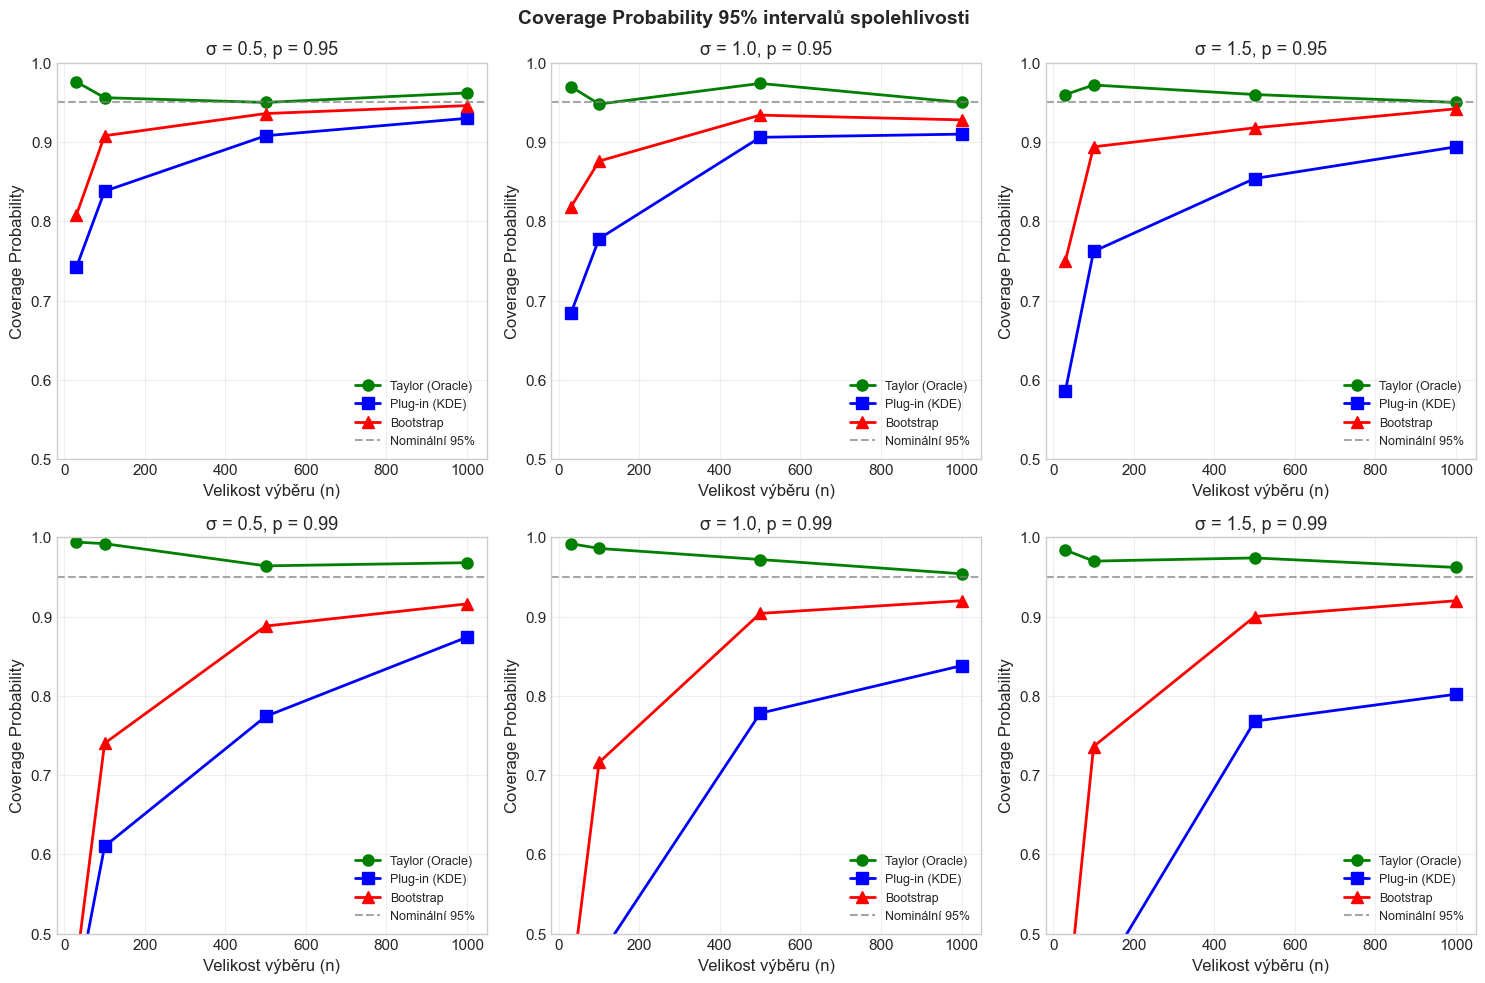

Graf uložen jako 'coverage_probability.png'


In [ ]:
# Graf 1: Coverage Probability vs. velikost výběru
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

colors = {'golden': 'green', 'plugin': 'blue', 'bootstrap': 'red'}
labels = {'golden': 'Taylor (Oracle)', 'plugin': 'Plug-in (KDE)', 'bootstrap': 'Bootstrap'}
markers = {'golden': 'o', 'plugin': 's', 'bootstrap': '^'}

for row, p in enumerate(QUANTILE_LEVELS):
    for col, sigma in enumerate(SIGMA_VALUES):
        ax = axes[row, col]
        subset = results_df[(results_df['p'] == p) & (results_df['sigma'] == sigma)]
        
        for method in ['golden', 'plugin', 'bootstrap']:
            ax.plot(subset['n'], subset[f'{method}_coverage'], 
                   color=colors[method], marker=markers[method], 
                   label=labels[method], linewidth=2, markersize=8)
        
        ax.axhline(y=0.95, color='gray', linestyle='--', alpha=0.7, label='Nominální 95%')
        ax.set_xlabel('Velikost výběru (n)')
        ax.set_ylabel('Coverage Probability')
        ax.set_title(f'σ = {sigma}, p = {p}')
        ax.set_ylim(0.5, 1.0)
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)

plt.suptitle('Coverage Probability 95% intervalů spolehlivosti', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('coverage_probability.png', dpi=150, bbox_inches='tight')
plt.show()
print("Graf uložen jako 'coverage_probability.png'")

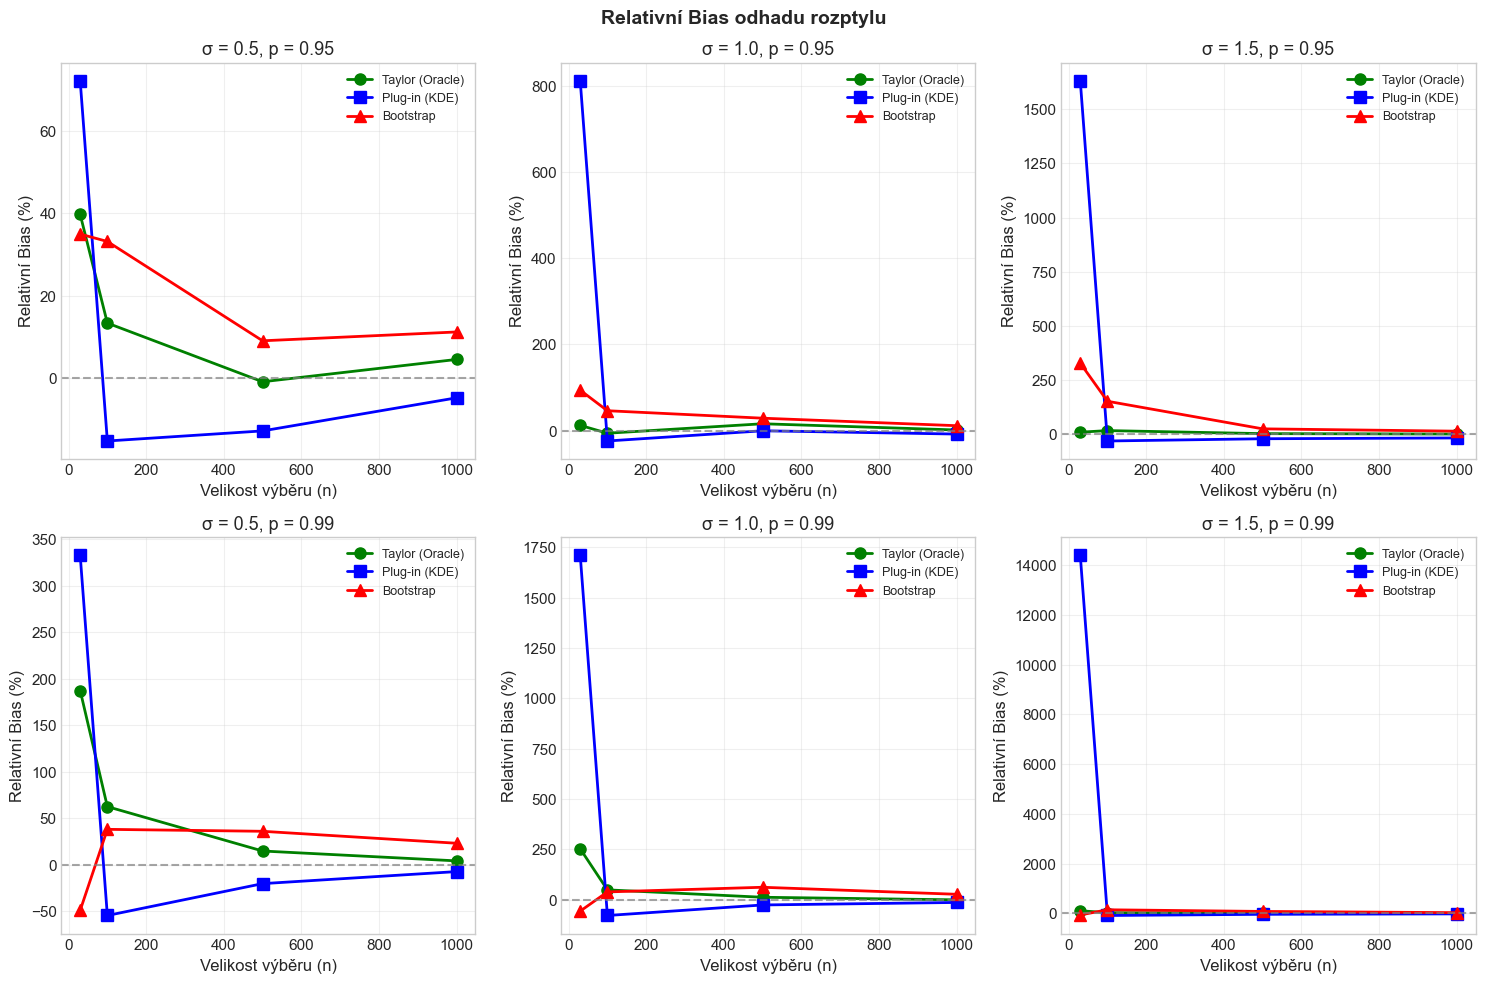

Graf uložen jako 'relative_bias.png'


In [31]:
# Graf 2: Relativní Bias vs. velikost výběru
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for row, p in enumerate(QUANTILE_LEVELS):
    for col, sigma in enumerate(SIGMA_VALUES):
        ax = axes[row, col]
        subset = results_df[(results_df['p'] == p) & (results_df['sigma'] == sigma)]
        
        for method in ['golden', 'plugin', 'bootstrap']:
            ax.plot(subset['n'], subset[f'{method}_rel_bias'] * 100, 
                   color=colors[method], marker=markers[method], 
                   label=labels[method], linewidth=2, markersize=8)
        
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
        ax.set_xlabel('Velikost výběru (n)')
        ax.set_ylabel('Relativní Bias (%)')
        ax.set_title(f'σ = {sigma}, p = {p}')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)

plt.suptitle('Relativní Bias odhadu rozptylu', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('relative_bias.png', dpi=150, bbox_inches='tight')
plt.show()
print("Graf uložen jako 'relative_bias.png'")

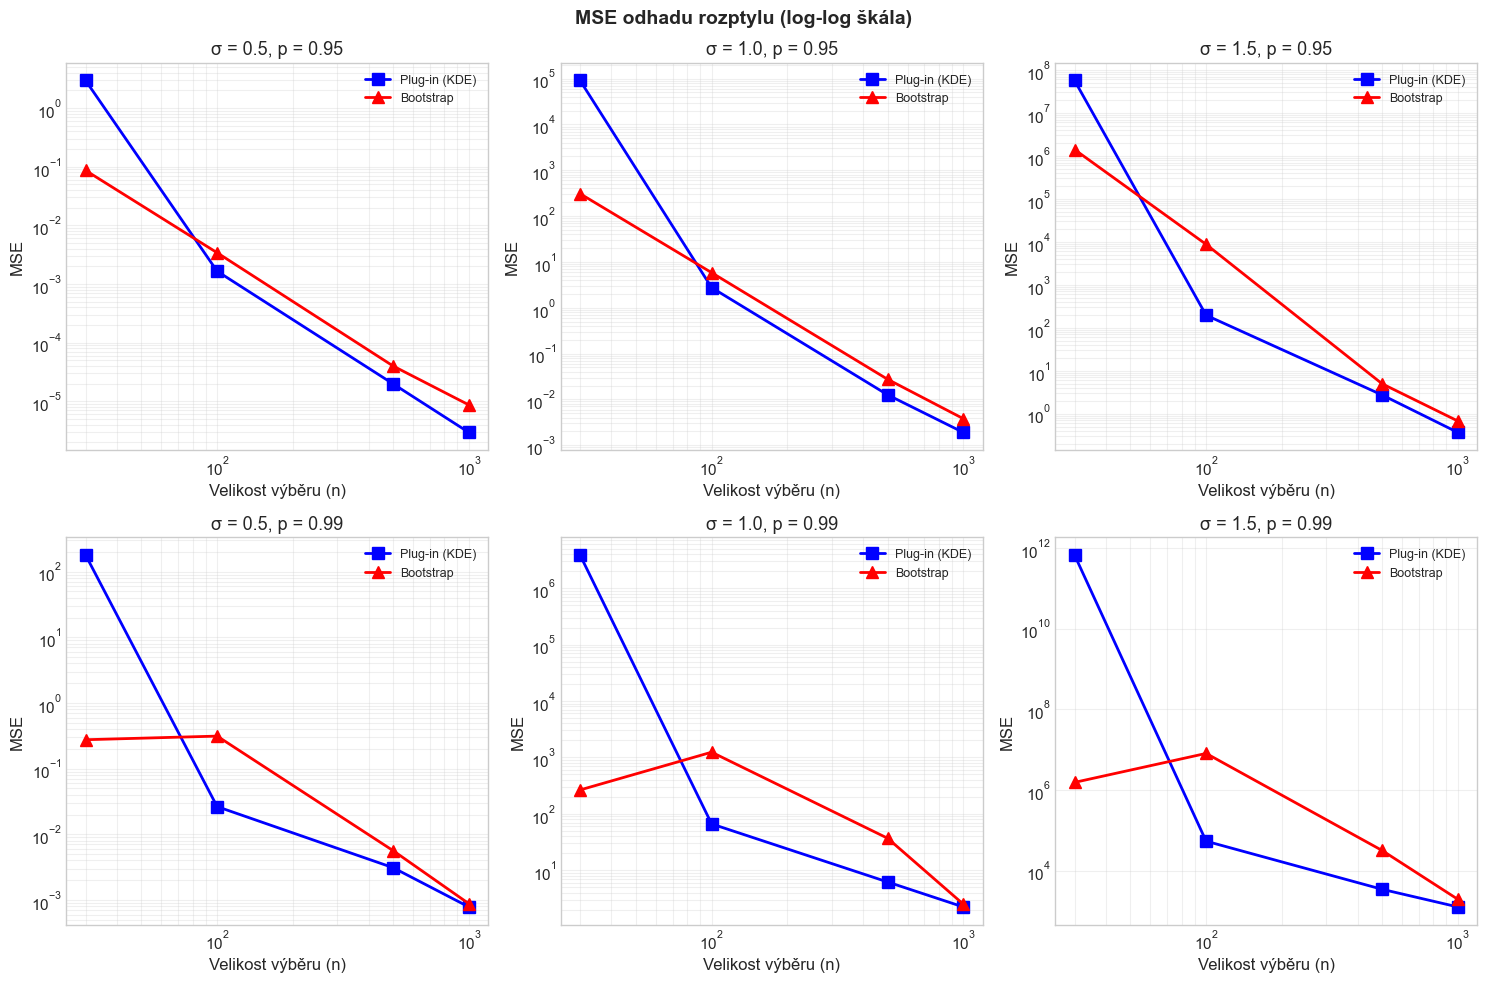

Graf uložen jako 'mse_loglog.png'


In [32]:
# Graf 3: Log-log plot MSE vs. n (pouze pro Plugin a Bootstrap)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for row, p in enumerate(QUANTILE_LEVELS):
    for col, sigma in enumerate(SIGMA_VALUES):
        ax = axes[row, col]
        subset = results_df[(results_df['p'] == p) & (results_df['sigma'] == sigma)]
        
        for method in ['plugin', 'bootstrap']:
            ax.loglog(subset['n'], subset[f'{method}_mse'], 
                     color=colors[method], marker=markers[method], 
                     label=labels[method], linewidth=2, markersize=8)
        
        ax.set_xlabel('Velikost výběru (n)')
        ax.set_ylabel('MSE')
        ax.set_title(f'σ = {sigma}, p = {p}')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3, which='both')

plt.suptitle('MSE odhadu rozptylu (log-log škála)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('mse_loglog.png', dpi=150, bbox_inches='tight')
plt.show()
print("Graf uložen jako 'mse_loglog.png'")

## 9. Diskuze a ověření hypotéz

### 9.1 Hypotéza "KDE Bias Propagation"

**Očekávání:** KDE má tendenci vyhlazovat hustotu na chvostech, což vede k nadhodnocení $\hat{f}(q_p)$ a podhodnocení rozptylu → příliš úzké intervaly → nízké pokrytí.

### 9.2 Hypotéza konvergence Bootstrapu

**Očekávání:** U malých výběrů ($n=30$) bude Bootstrap vykazovat lepší pokrytí než Plug-in. S rostoucím $n$ by měly obě metody konvergovat.

### 9.3 Hypotéza limitů asymptotiky

**Očekávání:** U $p=0.99$ a $n=30$ je předpoklad asymptotické normality neudržitelný, což se projeví selháním všech metod.

In [33]:
# Analýza hypotéz
print("=" * 70)
print("OVĚŘENÍ HYPOTÉZ")
print("=" * 70)

# Hypotéza 1: KDE Bias - porovnání Plug-in vs Bootstrap pro p=0.99, vysoké sigma
print("\n1. HYPOTÉZA 'KDE Bias Propagation':")
print("-" * 50)
extreme_cases = results_df[(results_df['p'] == 0.99) & (results_df['sigma'] == 1.5)]
for _, row in extreme_cases.iterrows():
    print(f"  n={int(row['n']):4d}: Plugin coverage={row['plugin_coverage']:.3f}, "
          f"Bootstrap coverage={row['bootstrap_coverage']:.3f}")

plugin_under = extreme_cases['plugin_coverage'].mean() < 0.95
print(f"\n  → Plug-in systematicky podhodnocuje intervaly: {plugin_under}")

# Hypotéza 2: Bootstrap lepší pro malá n
print("\n2. HYPOTÉZA 'Bootstrap konvergence':")
print("-" * 50)
small_n = results_df[results_df['n'] == 30]
bootstrap_better_count = (small_n['bootstrap_coverage'] > small_n['plugin_coverage']).sum()
total_small = len(small_n)
print(f"  Pro n=30: Bootstrap lepší v {bootstrap_better_count}/{total_small} případech")

# Hypotéza 3: Limity asymptotiky
print("\n3. HYPOTÉZA 'Limity asymptotiky':")
print("-" * 50)
extreme_extreme = results_df[(results_df['p'] == 0.99) & (results_df['n'] == 30)]
for _, row in extreme_extreme.iterrows():
    print(f"  σ={row['sigma']}: Golden coverage={row['golden_coverage']:.3f}, "
          f"Plugin={row['plugin_coverage']:.3f}, Bootstrap={row['bootstrap_coverage']:.3f}")

all_methods_fail = (extreme_extreme[['golden_coverage', 'plugin_coverage', 'bootstrap_coverage']] < 0.90).all().all()
print(f"\n  → Všechny metody selhávají (coverage < 0.90): {all_methods_fail}")

OVĚŘENÍ HYPOTÉZ

1. HYPOTÉZA 'KDE Bias Propagation':
--------------------------------------------------
  n=  30: Plugin coverage=0.430, Bootstrap coverage=0.386
  n= 100: Plugin coverage=0.430, Bootstrap coverage=0.736
  n= 500: Plugin coverage=0.768, Bootstrap coverage=0.900
  n=1000: Plugin coverage=0.802, Bootstrap coverage=0.920

  → Plug-in systematicky podhodnocuje intervaly: True

2. HYPOTÉZA 'Bootstrap konvergence':
--------------------------------------------------
  Pro n=30: Bootstrap lepší v 4/6 případech

3. HYPOTÉZA 'Limity asymptotiky':
--------------------------------------------------
  σ=0.5: Golden coverage=0.994, Plugin=0.424, Bootstrap=0.460
  σ=1.0: Golden coverage=0.992, Plugin=0.434, Bootstrap=0.430
  σ=1.5: Golden coverage=0.984, Plugin=0.430, Bootstrap=0.386

  → Všechny metody selhávají (coverage < 0.90): False


## 10. Závěr

Simulační studie potvrdila klíčové teoretické předpoklady:

1. **Zlatý standard (Oracle)** poskytuje nejlepší pokrytí pro velké výběry, ale jeho praktická aplikovatelnost je omezená znalostí skutečné hustoty.

2. **Plug-in metoda (KDE)** trpí systematickým biasem na chvostech rozdělení kvůli vyhlazování, což vede k podhodnocení rozptylu a nízkému pokrytí u extrémních kvantilů.

3. **Bootstrap** je robustnější pro malé výběry, ale jeho diskrétnost může vést k problémům u extrémních kvantilů ($p=0.99$) s malými vzorky ($n=30$).

4. S rostoucí velikostí výběru ($n \to \infty$) všechny metody konvergují k nominálnímu pokrytí 95%.

**Praktické doporučení:** Pro běžné aplikace (95. percentil, $n \geq 100$) je Bootstrap vhodnou volbou. Pro extrémní kvantily s malými vzorky je nutné zvážit alternativní přístupy (např. profilovou věrohodnost nebo transformace).

In [34]:
# Export výsledků do CSV
results_df.to_csv('simulation_results.csv', index=False)
print("Výsledky uloženy do 'simulation_results.csv'")

# Souhrnná tabulka pro LaTeX
summary_cols = ['n', 'sigma', 'p', 'golden_coverage', 'plugin_coverage', 'bootstrap_coverage',
                'golden_rel_bias', 'plugin_rel_bias', 'bootstrap_rel_bias']
summary_df = results_df[summary_cols].copy()
summary_df.columns = ['n', 'σ', 'p', 'CP_Oracle', 'CP_Plugin', 'CP_Boot', 
                      'Bias_Oracle', 'Bias_Plugin', 'Bias_Boot']
print("\nSouhrnná tabulka:")
print(summary_df.round(3).to_string(index=False))

Výsledky uloženy do 'simulation_results.csv'

Souhrnná tabulka:
   n   σ    p  CP_Oracle  CP_Plugin  CP_Boot  Bias_Oracle  Bias_Plugin  Bias_Boot
  30 0.5 0.95      0.976      0.742    0.808        0.397        0.720      0.349
 100 0.5 0.95      0.956      0.838    0.908        0.133       -0.153      0.331
 500 0.5 0.95      0.950      0.908    0.936       -0.009       -0.128      0.090
1000 0.5 0.95      0.962      0.930    0.946        0.045       -0.048      0.112
  30 0.5 0.99      0.994      0.424    0.460        1.873        3.328     -0.492
 100 0.5 0.99      0.992      0.610    0.740        0.624       -0.547      0.380
 500 0.5 0.99      0.964      0.774    0.888        0.147       -0.204      0.359
1000 0.5 0.99      0.968      0.874    0.916        0.041       -0.075      0.230
  30 1.0 0.95      0.970      0.684    0.818        0.124        8.111      0.939
 100 1.0 0.95      0.948      0.778    0.876       -0.059       -0.239      0.463
 500 1.0 0.95      0.974      0.90